# Indiana Timeseries

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
#from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
#import pmdarima as pm

### Loading data

In [33]:
df_emp=pd.read_pickle("emp_dfpkl.sec")

In [34]:
df_emp= df_emp[['Michigan','California','Ohio','Texas','Indiana']]

In [35]:
emp_final= df_emp[238:]

#### Indiana Dataset

In [36]:
indiana=emp_final['Indiana']

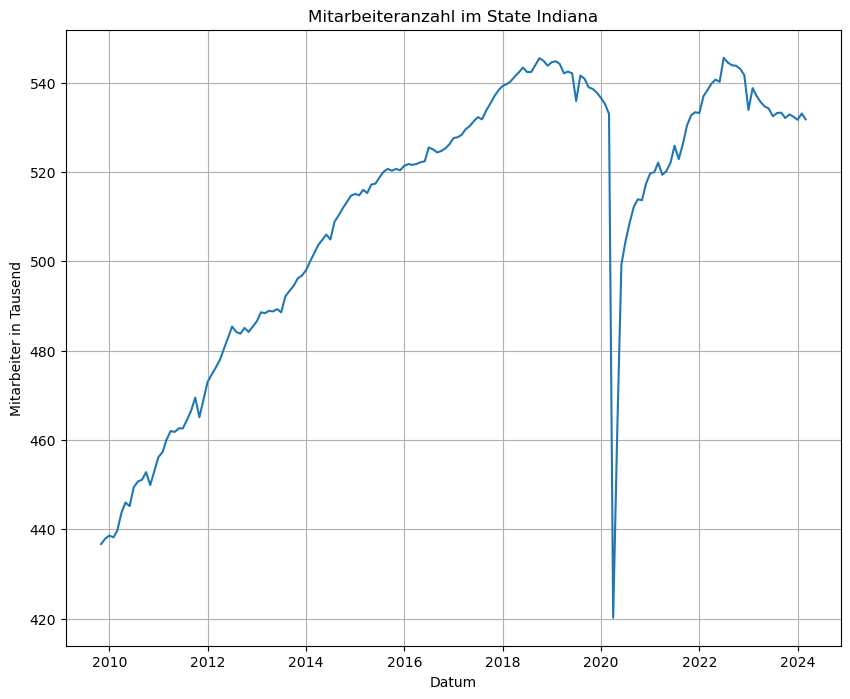

In [37]:
plt.figure(figsize=(10, 8))
plt.plot(indiana)
plt.title('Mitarbeiteranzahl im State Indiana')
plt.xlabel('Datum')
plt.ylabel('Mitarbeiter in Tausend')
plt.grid(True)
plt.show()

### Test und Trainingsdaten

In [38]:
#Test und Traingsdaten
train = indiana[:int(0.9 * len(indiana))]
test = indiana[int(0.9 * len(indiana)):]

In [39]:
pred_start= test.index[0]
pred_end= test.index[-1]

In [40]:
print(f"Länge des Trainingsdatensatzes: {len(train)}")
print(f"Länge des Testdatensatzes: {len(test)}")

Länge des Trainingsdatensatzes: 155
Länge des Testdatensatzes: 18


# Samira

### Besteht aus ARIMA (AR -> Autoregression, I -> Differenzierung und MA-> Gleitender Durschschnitt) plus Saisonale Komponenten S auf ARIMA 

## 1. Stationary

In [41]:
result = adfuller(indiana)
print(f'ADF Test Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Test Statistic: -2.3539823192386526
p-value: 0.15514782093438056


keine stationarity

In [42]:
indiana_diff= indiana.diff().dropna()

In [43]:
result = adfuller(indiana_diff)
print(f'ADF Test Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Test Statistic: -12.80926177399273
p-value: 6.499392267427841e-24


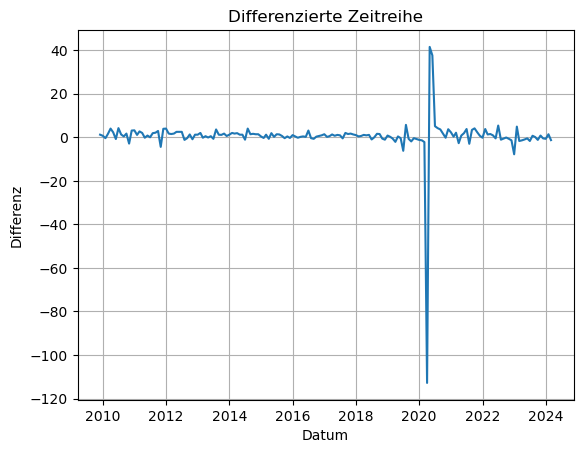

In [44]:
plt.plot(indiana_diff)
plt.title('Differenzierte Zeitreihe')
plt.xlabel('Datum')
plt.ylabel('Differenz')
plt.grid(True)
plt.show()

## 2. PACF und ACF

In [45]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

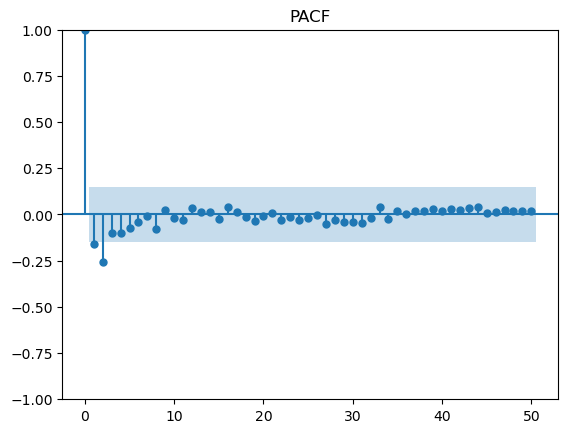

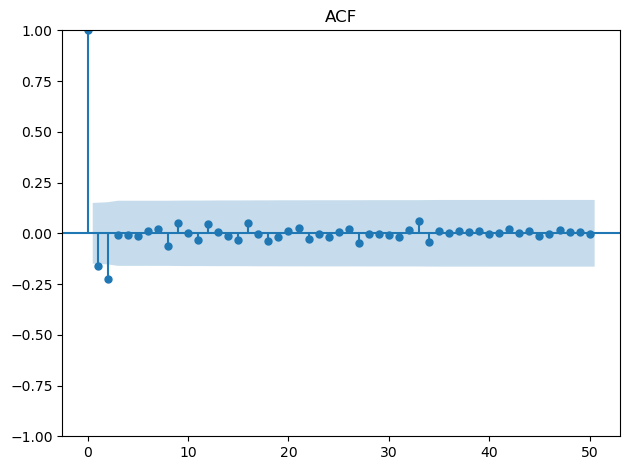

In [46]:
plot_pacf(indiana_diff,lags=50,title='PACF')
plot_acf(indiana_diff,lags=50,title='ACF')
plt.tight_layout()
plt.show()

### Gleitender Durchschnitt mit rolling window

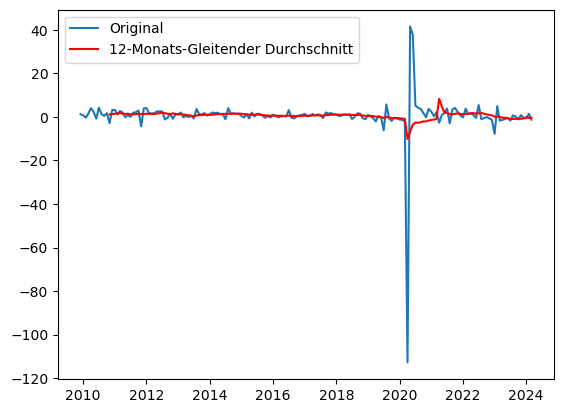

In [47]:
MA = indiana_diff.rolling(window=12).mean()
plt.plot(indiana_diff, label='Original')
plt.plot(MA, label='12-Monats-Gleitender Durchschnitt', color='red')
plt.legend()
plt.show()

### Gleitender durschnitt mit ARIMA

In [52]:
from statsmodels.tsa.arima.model import ARIMA

In [55]:
#MA_modell= ARIMA(train,order=(0,0,2)) # -> nur MA berechnung
MA_modell= ARIMA(train,order=(0,0,2)) # -> nur MA berechnung

In [57]:
MA_fit= MA_modell.fit()
print(MA_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                Indiana   No. Observations:                  155
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -647.494
Date:                Sat, 05 Oct 2024   AIC                           1302.989
Time:                        22:40:17   BIC                           1315.162
Sample:                    11-01-2009   HQIC                          1307.933
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        507.1314      4.474    113.354      0.000     498.363     515.900
ma.L1          1.0986      0.043     25.543      0.000       1.014       1.183
ma.L2          0.5731      0.048     11.896      0.0

P > Z sagt aus welche Lags signifikant sind. alles unter 0.05 sind nicht signifikant

In [58]:
ma_pred=MA_fit.predict(start=pred_start, end= pred_end)
residuals=test-ma_pred

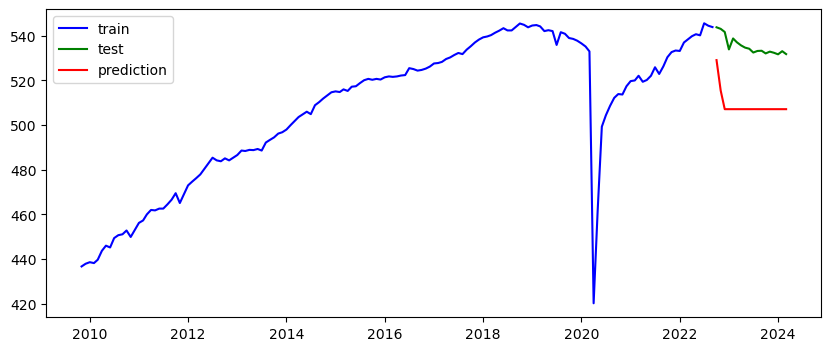

In [59]:
plt.figure(figsize=(10,4))
plt.plot(train, label='train',color= 'blue')
plt.plot(test, label='test',color='green')
plt.plot( ma_pred, label='prediction',color='red')
plt.legend()
plt.show()

# AR -> Autoregression 

In [60]:
ar_modell= ARIMA(train,order=(2,0,0))
ar_fit=ar_modell.fit()
print(ar_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                Indiana   No. Observations:                  155
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -580.571
Date:                Sat, 05 Oct 2024   AIC                           1169.141
Time:                        22:40:37   BIC                           1181.315
Sample:                    11-01-2009   HQIC                          1174.086
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        502.2988     63.267      7.939      0.000     378.298     626.300
ar.L1          0.8315      0.067     12.396      0.000       0.700       0.963
ar.L2          0.1349      0.043      3.128      0.0

Prediction with Ar models

In [61]:
ar_pred=ar_fit.predict(start=pred_start, end= pred_end)
residuals=test-ar_pred

Ploting

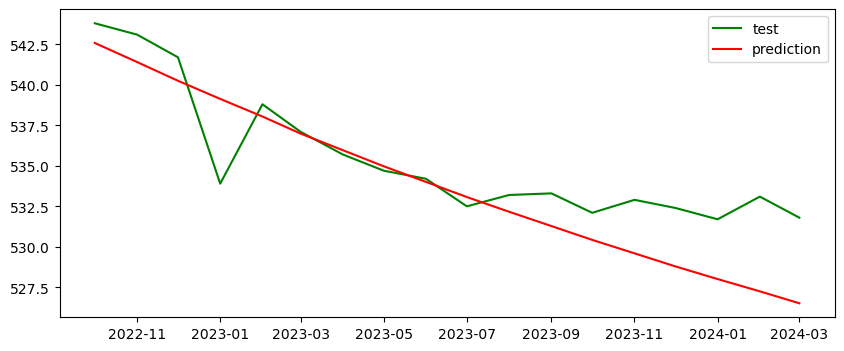

In [62]:
plt.figure(figsize=(10,4))
#plt.plot(train, label='train',color= 'blue')
plt.plot(test, label='test',color='green')
plt.plot( ar_pred, label='prediction',color='red')
plt.legend()
plt.show()

### Evaulation

In [63]:
test_mae = mean_absolute_error(test, ar_pred)
test_mse = mean_squared_error(test, ar_pred)
test_rmse = mean_squared_error(test, ar_pred, squared=False)
test_r2 = r2_score(test, ar_pred)

In [64]:
print('mae',test_mae)
print('mse',test_mse)
print('rmse',test_rmse)
print('r2',test_r2)

mae 2.1233336520173034
mse 7.918125660369733
rmse 2.813916427396118
r2 0.4599641486562016


# Arima (p,d,q)

In [85]:
arima_modell= ARIMA(train, order=(33,1,21)) #best order 3,0,1
arima_fit=arima_modell.fit()
print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                Indiana   No. Observations:                  155
Model:               ARIMA(33, 1, 21)   Log Likelihood                -566.973
Date:                Sat, 05 Oct 2024   AIC                           1243.945
Time:                        22:45:37   BIC                           1410.978
Sample:                    11-01-2009   HQIC                          1311.794
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6081    546.017     -0.001      0.999   -1070.782    1069.566
ar.L2         -0.1598    112.180     -0.001      0.999    -220.029     219.709
ar.L3          0.1279    165.648      0.001      0.9

In [88]:
arima_pred=arima_fit.predict(start=pred_start, end= pred_end)
residuals=test-arima_pred

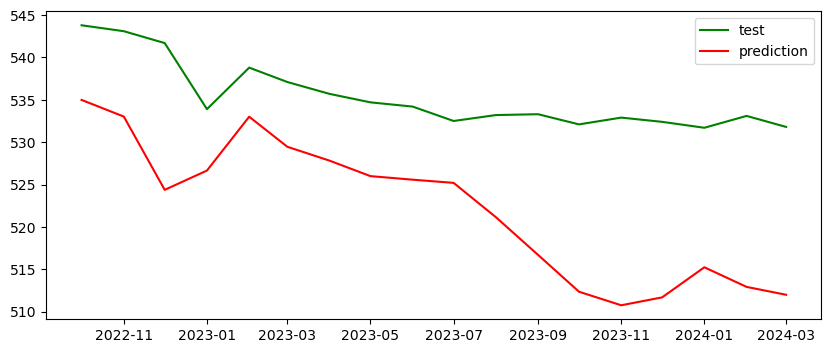

In [89]:
plt.figure(figsize=(10,4))
#plt.plot(train, label='train',color= 'blue')
plt.plot(test, label='test',color='green')
plt.plot( arima_pred, label='prediction',color='red')
plt.legend()
plt.show()

# Evaulation

In [90]:
test_mae = mean_absolute_error(test, arima_pred)
test_mse = mean_squared_error(test, arima_pred)
test_rmse = mean_squared_error(test, arima_pred, squared=False)
test_r2 = r2_score(test, arima_pred)

In [91]:
print('mae',test_mae)
print('mse',test_mse)
print('rmse',test_rmse)
print('r2',test_r2)

mae 13.178550432555287
mse 205.18820404947553
rmse 14.32439192599377
r2 -12.994345532322528


# Sarima (p,d,q)(P,D,Q)s

In [92]:
my_order = (2,1,2)
my_sorder = (1,1,1,12)

In [93]:
sarima_modell = SARIMAX(train, order=my_order, seasonal_order=my_sorder)
sarima_fit=sarima_modell.fit()
print(sarima_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                              Indiana   No. Observations:                  155
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 12)   Log Likelihood                -539.231
Date:                              Sat, 05 Oct 2024   AIC                           1092.461
Time:                                      23:29:15   BIC                           1113.152
Sample:                                  11-01-2009   HQIC                          1100.869
                                       - 09-01-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0188      0.740      0.025      0.980      -1.432       1.469
ar.L2          0.02

In [94]:
sarima_pred=sarima_fit.predict(start=pred_start, end= pred_end)
residuals=test-sarima_pred

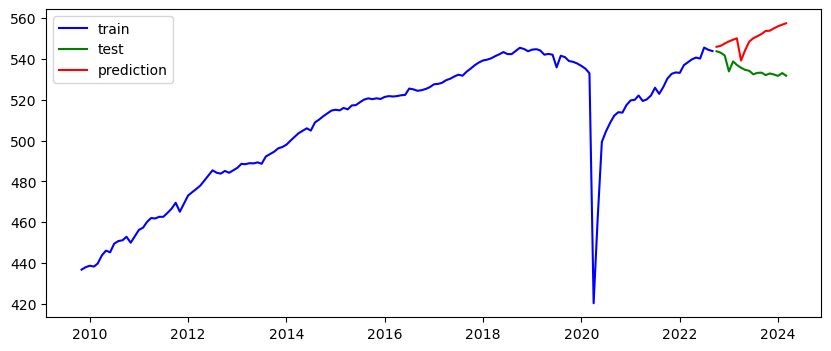

In [95]:
plt.figure(figsize=(10,4))
plt.plot(train, label='train',color= 'blue')
plt.plot(test, label='test',color='green')
plt.plot( sarima_pred, label='prediction',color='red')
plt.legend()
plt.show()

# Evaulation

In [96]:
test_mae = mean_absolute_error(test, sarima_pred)
test_mse = mean_squared_error(test, sarima_pred)
test_rmse = mean_squared_error(test, sarima_pred, squared=False)
test_r2 = r2_score(test, sarima_pred)

In [97]:
print('mae',test_mae)
print('mse',test_mse)
print('rmse',test_rmse)
print('r2',test_r2)

mae 15.049011811240064
mse 282.93806051768127
rmse 16.820762780494864
r2 -18.297078998629377


# Auto Sarima

In [ ]:
import pmdarima as pm

In [98]:
auto_sarima = pm.auto_arima(train,d=None, stationary= False,
                           m=12, start_p=0, max_p=11, max_d= 1,approximation = True, start_q=0, max_q=11, start_P=0, D=None, start_Q=0, max_P=11, max_D=1, max_Q=11, trace=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1159.782, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1159.471, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1155.036, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1158.482, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1153.325, Time=0.03 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1155.045, Time=0.10 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=1157.008, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1146.343, Time=0.04 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=1148.001, Time=0.10 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=1147.982, Time=0.12 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=1149.898, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1157.755, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=1146.419, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=1146.020, Time=0.06 sec
 ARIMA(1,1,2)(1,0,0

In [99]:
my_order = (4,1,1)
my_sorder = (1,1,1,12)

In [100]:
a_sarima = SARIMAX(train, order=my_order, seasonal_order=my_sorder)
auto_s_fit = a_sarima.fit()
print(auto_s_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                            Indiana   No. Observations:                  155
Model:             SARIMAX(4, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -539.199
Date:                            Sat, 05 Oct 2024   AIC                           1094.398
Time:                                    23:29:26   BIC                           1118.045
Sample:                                11-01-2009   HQIC                          1104.007
                                     - 09-01-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3831      0.723      0.530      0.596      -1.034       1.800
ar.L2         -0.1680      0.209   

In [101]:
auto_sarima_pred=auto_s_fit.predict(start=pred_start, end= pred_end)
residuals=test-auto_sarima_pred

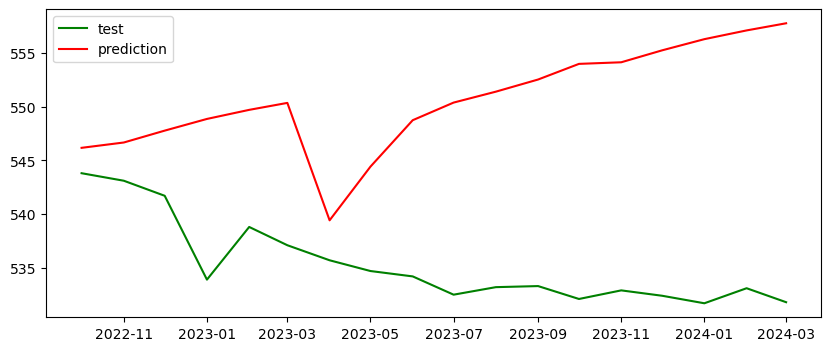

In [102]:
plt.figure(figsize=(10,4))
#plt.plot(train, label='train',color= 'blue')
plt.plot(test, label='test',color='green')
plt.plot( auto_sarima_pred, label='prediction',color='red')
plt.legend()
plt.show()

# Evaulation

In [103]:
test_mae = mean_absolute_error(test, auto_sarima_pred)
test_mse = mean_squared_error(test, auto_sarima_pred)
test_rmse = mean_squared_error(test, auto_sarima_pred, squared=False)
test_r2 = r2_score(test, auto_sarima_pred)

In [104]:
print('mae',test_mae)
print('mse',test_mse)
print('rmse',test_rmse)
print('r2',test_r2)

mae 15.262771411065122
mse 289.6344937268485
rmse 17.018651348648298
r2 -18.75379238816034
